
# MACHINE LEARNING II — ACTIVIDAD 4  
### **Autores: Marcelo Carmona — Paula Álvarez**


In [48]:
#Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
#Montar google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [57]:
ruta_driver = "/content/drive/MyDrive/Data Science/Machine Learning II/Actividad IV"
df = pd.read_csv(ruta_driver + "/data-churn.csv")

print("Shape inicial del dataset:", df.shape)
print("Valores únicos en Churn antes de map:", df['Churn'].unique())


Shape inicial del dataset: (7043, 21)
Valores únicos en Churn antes de map: ['No' 'Yes']


In [7]:
#ASGINACION DE VARIABLE OBJETIVO "Churn"

# Asignar directamente la variable objetivo, ya que es conocida
target = "Churn"

# revisar si está en formato Yes/No
if df[target].dtype == "object":
    df[target] = df[target].map({"Yes": 1, "No": 0, "yes": 1, "no": 0}).astype("float")

# Convertir a entero (0/1)
df[target] = df[target].astype(int)

# Mostrar primeras filas y distribución de clases
print(df.head())
print(df[target].value_counts(normalize=True))
print(df['Churn'].unique()) #con esto aseguro que todos los valores de columna objetivo Churn sean 0 o 1.
print(df['Churn'].value_counts())
len(df)


   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

7043

#Preprocesamiento

In [56]:


# Separar features y target
X = df.drop(columns=["Churn"])
y = df["Churn"].astype(int)

# Detectar columnas numéricas y categóricas
num_cols = X.select_dtypes(include=np.number).columns
cat_cols = X.select_dtypes(exclude=np.number).columns

# Definir transformadores
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Preprocesador combinado
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
], verbose_feature_names_out=False)

# Definir semilla para reproducibilidad SEED = 42 # puedes usar cualquier número entero
SEED = 42
# Split estratificado
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# Fit-transform en train y transform en test
X_train = preprocessor.fit_transform(X_train_raw)
X_test  = preprocessor.transform(X_test_raw)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

print("Train raw:", X_train_raw.shape)
print("Test raw:", X_test_raw.shape)
print("Train final:", X_tr.shape)
print("Validation:", X_val.shape)
print("Test final:", X_test.shape)

total = len(X_tr) + len(X_val) + len(X_test)
print("Total registros:", total)



Train shape: (5634, 10954) Test shape: (1409, 10954)
Train raw: (5634, 20)
Test raw: (1409, 20)
Train final: (4507, 10954)
Validation: (1127, 10954)
Test final: (1409, 10954)
Total registros: 7043


In [23]:

class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# creamos dataset
train_ds = TabularDataset(X_train, y_train)
test_ds  = TabularDataset(X_test, y_test)

len(train_ds), len(test_ds)


(5634, 1409)

#Paso 1. MLP, perceptrón multi-capa

b) Implemente una red neuronal densa (MLP) con al menos:
• Una capa de entrada acorde al número de features.
• Una o dos capas ocultas.
• Una capa de salida con activación sigmoidal.

c) Justifique la elección de:
• Número de capas y neuronas.
• Función de activación en capas ocultas.
• Función de pérdida y optimizador.

d) Entrene el modelo y registre la evolución de la función de pérdida y métricas de desempeño.

###Entrenamiento base

In [26]:

input_dim = X_train.shape[1]

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=(256, 64), dropout=0.0):
        super(MLP, self).__init__()
        layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev_dim = h_dim

        layers.append(nn.Linear(prev_dim, 1)) # Output layer
        layers.append(nn.Sigmoid()) # Sigmoid activation for binary classification

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

model = MLP(input_dim, hidden_dims=(64, 32), dropout=0.1) # Initialize with desired parameters
print(model)


MLP(
  (net): Sequential(
    (0): Linear(in_features=10954, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


La neuronal está recibiendo 10.954 variables de entrada (por el one-hot encoding de categóricas).

Está aprendiendo representaciones compactas en capas ocultas (256 → 64).

Finalmente, entrega una probabilidad de churn para cada cliente.

In [27]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

train_loader = DataLoader(TabularDataset(X_tr, y_tr), batch_size=32, shuffle=True)
val_loader   = DataLoader(TabularDataset(X_val, y_val), batch_size=256, shuffle=False)

mlp = MLP(input_dim=X_train.shape[1], hidden_dims=(64, 32), dropout=0.1)

In [71]:
#=======================================================
#Tres funciones PyTorch
#Entrenar (train_torch_binary).
#Predecir probabilidades (predict_proba_torch).
#Evaluar con métricas (binary_classification_metrics).
#=======================================================

def train_torch_binary(model, train_loader, val_loader, lr=1e-3, epochs=25, verbose=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    history = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct_train, total_train = 0, 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = (outputs >= 0.5).int()
            correct_train += (preds == y_batch.int()).sum().item()
            total_train += y_batch.size(0)

        train_acc = correct_train / total_train

        model.eval()
        val_loss = 0
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for X_batch_val, y_batch_val in val_loader:
                outputs_val = model(X_batch_val).squeeze()
                loss_val = criterion(outputs_val, y_batch_val)
                val_loss += loss_val.item()
                preds_val = (outputs_val >= 0.5).int()
                correct_val += (preds_val == y_batch_val.int()).sum().item()
                total_val += y_batch_val.size(0)

        val_acc = correct_val / total_val

        history["epoch"].append(epoch + 1)
        history["train_loss"].append(train_loss / len(train_loader))
        history["val_loss"].append(val_loss / len(val_loader))
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        if verbose:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss / len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Acc: {val_acc:.4f}")

    end_time = time.time()
    training_time = end_time - start_time
    return history, training_time

def predict_proba_torch(model, X_data):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X_data, dtype=torch.float32)
        outputs = model(X_tensor).squeeze()
    return outputs.numpy()

def binary_classification_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1_score": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_prob)
    }
    return metrics, y_pred


Epoch 1/25 - Train Loss: 0.4895, Train Acc: 0.7681, Val Loss: 0.4338, Val Acc: 0.8128
Epoch 2/25 - Train Loss: 0.4015, Train Acc: 0.8147, Val Loss: 0.4192, Val Acc: 0.8083
Epoch 3/25 - Train Loss: 0.3190, Train Acc: 0.8680, Val Loss: 0.4263, Val Acc: 0.8154
Epoch 4/25 - Train Loss: 0.1374, Train Acc: 0.9725, Val Loss: 0.4705, Val Acc: 0.7622
Epoch 5/25 - Train Loss: 0.0260, Train Acc: 0.9976, Val Loss: 0.4673, Val Acc: 0.7817
Epoch 6/25 - Train Loss: 0.0093, Train Acc: 0.9993, Val Loss: 0.4843, Val Acc: 0.7764
Epoch 7/25 - Train Loss: 0.0050, Train Acc: 0.9998, Val Loss: 0.4646, Val Acc: 0.7853
Epoch 8/25 - Train Loss: 0.0028, Train Acc: 1.0000, Val Loss: 0.4921, Val Acc: 0.7675
Epoch 9/25 - Train Loss: 0.0020, Train Acc: 1.0000, Val Loss: 0.4838, Val Acc: 0.7799
Epoch 10/25 - Train Loss: 0.0013, Train Acc: 1.0000, Val Loss: 0.4831, Val Acc: 0.7826
Epoch 11/25 - Train Loss: 0.0011, Train Acc: 1.0000, Val Loss: 0.5078, Val Acc: 0.7720
Epoch 12/25 - Train Loss: 0.0007, Train Acc: 1.0000,

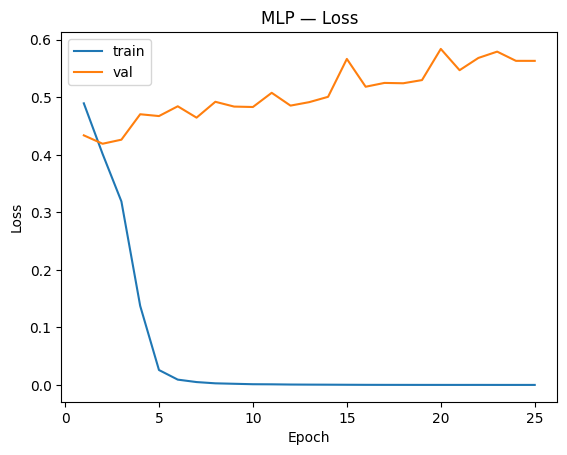

,0
accuracy,0.776437
precision,0.592476
recall,0.505348
f1_score,0.545455
roc_auc,0.806099


In [30]:

#Se utiliza función train_torch_binary con:
#El modelo mlp.
#Los DataLoader de entrenamiento y validación.
#Tasa de aprendizaje lr=0.001.
#25 épocas.
#Se obtiene:
#hist: historial con pérdidas y accuracies por época.
#train_time: tiempo total de entrenamiento.


hist, train_time = train_torch_binary(mlp, train_loader, val_loader, lr=1e-3, epochs=25, verbose=True)
print(f"train_time(s)={train_time:.2f}")

# Curva de pérdida
fig, ax = plt.subplots()
ax.plot(hist["epoch"], hist["train_loss"], label="train")
ax.plot(hist["epoch"], hist["val_loss"], label="val")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("MLP — Loss")
ax.legend()
plt.show()

# Métricas en test
y_prob = predict_proba_torch(mlp, X_test)
metrics, y_pred = binary_classification_metrics(y_test.values, y_prob)
pd.Series(metrics)

###Interpretacion

Accuracy = 0,776  
El modelo acierta en ~77.6% de los casos.
👉 Correcto en general, pero puede ocultar problemas si las clases están desbalanceadas.

Precision = 0,592  
De todos los clientes que el modelo predijo como churn, ~59% realmente lo eran.
👉 La precisión es moderada: hay bastantes falsos positivos.

Recall = 0,505  
El modelo detecta ~50.5% de los clientes que realmente hicieron churn.
👉 Aquí está la alerta: el modelo está dejando escapar casi la mitad de los casos de churn (falsos negativos).

F1-score = 0,545  
Balance entre precision y recall.
👉 El valor es bajo, lo que confirma que el modelo no logra un buen equilibrio.

ROC-AUC = 0,806  
El área bajo la curva ROC es buena (>0.8).
👉 Significa que el modelo tiene capacidad de discriminación entre churn y no churn, aunque su umbral de decisión (0.5) no está optimizado.

In [41]:


def plot_confusion(y_true, y_pred, title="Confusion Matrix"):
    """
    Grafica matriz de confusión con barra de color.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", cbar=True,
                xticklabels=["0", "1"],
                yticklabels=["0", "1"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()


def plot_roc_pr(y_true, y_prob, title="ROC & Precision-Recall"):
    """
    Grafica curva ROC y curva Precision-Recall en dos subplots.
    """
    fig, ax = plt.subplots(1, 2, figsize=(12,5))

    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    ax[0].plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.2f}")
    ax[0].plot([0,1], [0,1], color="gray", linestyle="--")
    ax[0].set_xlabel("False Positive Rate")
    ax[0].set_ylabel("True Positive Rate")
    ax[0].set_title(f"{title} — ROC Curve")
    ax[0].legend(loc="lower right")

    # Precision-Recall
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ax[1].plot(recall, precision, color="green", lw=2)
    ax[1].set_xlabel("Recall")
    ax[1].set_ylabel("Precision")
    ax[1].set_title(f"{title} — Precision-Recall Curve")

    plt.tight_layout()
    plt.show()


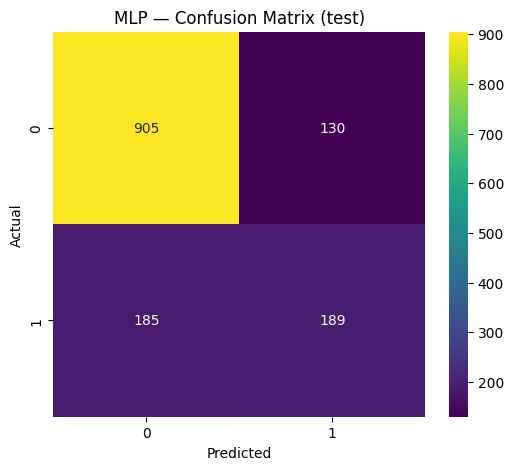

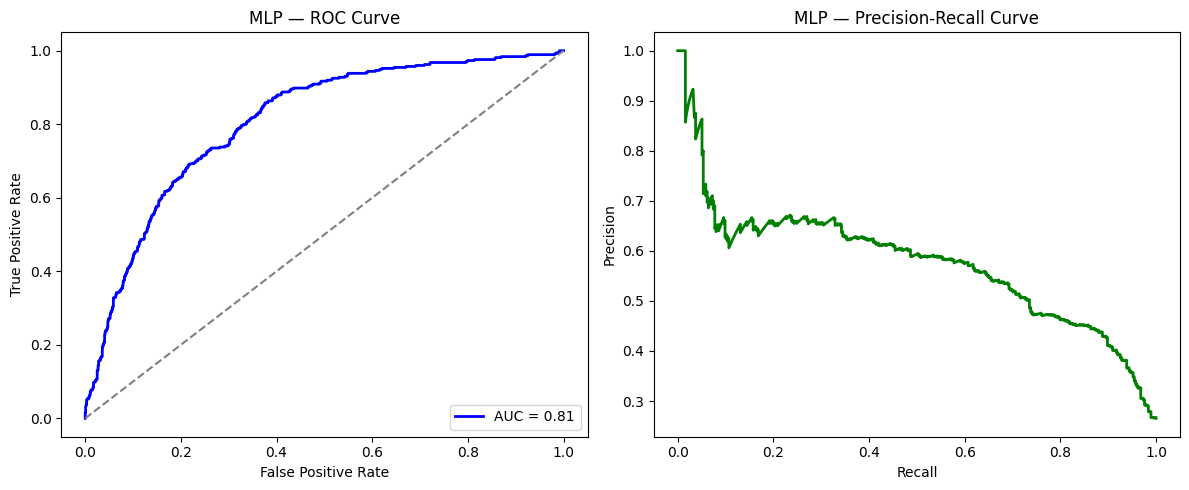

In [42]:
plot_confusion(y_test.values, y_pred, title="MLP — Confusion Matrix (test)")
plot_roc_pr(y_test.values, y_prob, title="MLP")


###Interpretacion
Matriz de confusión: El modelo detecta churn con moderada precisión, pero comete errores en ambas clases.

ROC Curve: AUC ≈ 0.81
→ El modelo tiene buena capacidad de discriminación entre clases.

Precision-Recall Curve:
→ Muestra que el modelo pierde precisión al intentar mejorar el recall, típico en datasets desbalanceados.

**Paso 2. Entrenamiento de MLP**

a) Analice el efecto del learning rate probando al menos dos valores distintos.

b) Analice el efecto del batch size (por ejemplo: 16, 32, 64).

c) Discuta convergencia, estabilidad y tiempo de entrenamiento.

d) Reporte en el conjunto de test: Accuracy, Precision, Recall, F1, AUC-ROC y PR-AUC.

e) Grafique curvas ROC y Precision–Recall.

      lr  batch_size  train_time  accuracy  precision    recall  f1_score  \
0  0.001          16   80.593277  0.758694   0.534553  0.703209  0.607390   
1  0.010          16  103.423951  0.723918   0.484536  0.628342  0.547148   

    roc_auc  
0  0.808595  
1  0.766711  


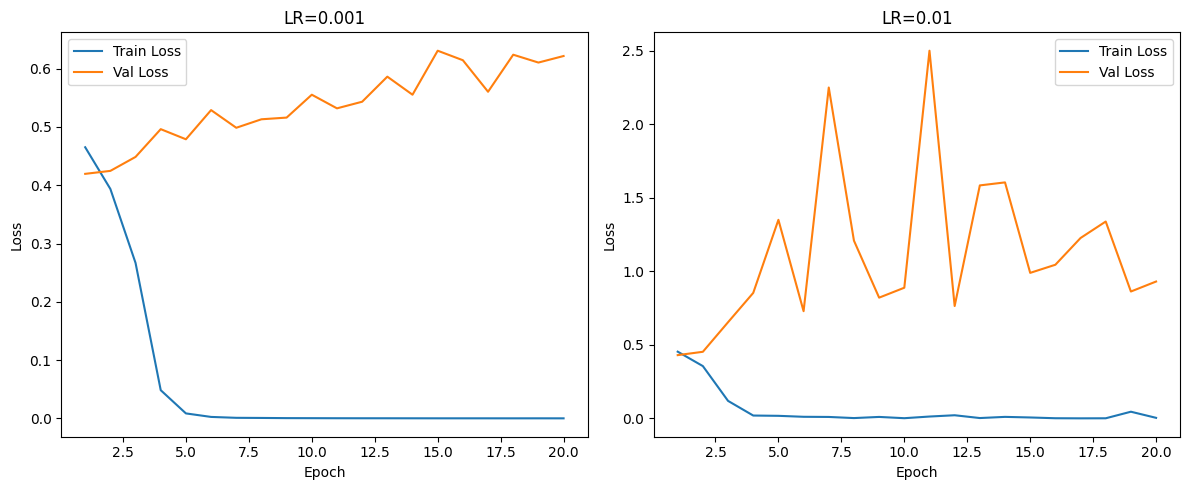

In [43]:

# -----------------------------
# Función experimento
# -----------------------------
def run_mlp_experiment(lr, batch_size, X_tr, y_tr, X_val, y_val, X_test, y_test, X_train, epochs=20):
    train_loader = DataLoader(TabularDataset(X_tr, y_tr), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(TabularDataset(X_val, y_val), batch_size=256, shuffle=False)
    mlp = MLP(input_dim=X_train.shape[1], hidden_dims=(64,32), dropout=0.1)
    hist, train_time = train_torch_binary(mlp, train_loader, val_loader, lr=lr, epochs=epochs, verbose=False)
    y_prob = predict_proba_torch(mlp, X_test)
    metrics, y_pred = binary_classification_metrics(y_test.values, y_prob)
    row = {
        "lr": lr,
        "batch_size": batch_size,
        "train_time": train_time,
        "accuracy": metrics["accuracy"],
        "precision": metrics["precision"],
        "recall": metrics["recall"],
        "f1_score": metrics["f1_score"],
        "roc_auc": metrics["roc_auc"]
    }
    return row, hist

# -----------------------------
# Experimentos con distintos LR
# -----------------------------
lrs = [1e-3, 1e-2]   # dos valores distintos de learning rate
batches = [16]       # puedes variar también batch_size si quieres

rows = []
histories = {}

for lr in lrs:
    for bs in batches:
        row, hist = run_mlp_experiment(lr, bs, X_tr, y_tr, X_val, y_val, X_test, y_test, X_train, epochs=20)
        rows.append(row)
        histories[(lr, bs)] = hist

results_mlp = pd.DataFrame(rows).sort_values(["lr", "batch_size"])
print(results_mlp)

# -----------------------------
# Graficar curvas de pérdida
# -----------------------------
fig, ax = plt.subplots(1, len(lrs), figsize=(12,5))
for i, lr in enumerate(lrs):
    hist = histories[(lr, batches[0])]
    ax[i].plot(hist["epoch"], hist["train_loss"], label="Train Loss")
    ax[i].plot(hist["epoch"], hist["val_loss"], label="Val Loss")
    ax[i].set_title(f"LR={lr}")
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Loss")
    ax[i].legend()
plt.tight_layout()
plt.show()


🔍 Interpretación

**LR = 0.001 (más bajo)**

Mejor accuracy y ROC-AUC → el modelo discrimina mejor entre clases.

Recall más alto (0.703) → detecta más churners reales.

F1-score superior (0.607) → mejor equilibrio entre precisión y recall.

Entrenamiento más estable y rápido (menos tiempo que con LR=0.01). Este valor favorece la generalización.

**LR = 0.010 (más alto)**

Accuracy y ROC-AUC bajan → el modelo pierde capacidad de discriminación.

Recall también baja (0.628), aunque sigue razonable.

F1-score más bajo (0.547).

Entrenamiento toma más tiempo (~103 s).
Este valor provoca oscilaciones y sobreajuste, el modelo aprende demasiado rápido y pierde estabilidad.

   batch_size  train_time  accuracy  precision    recall  f1_score   roc_auc
0          16   81.755921  0.724627   0.480114  0.451872  0.465565  0.734664
1          32   41.302457  0.772889   0.567500  0.606952  0.586563  0.810437
2          64   26.570782  0.743790   0.513919  0.641711  0.570749  0.795226


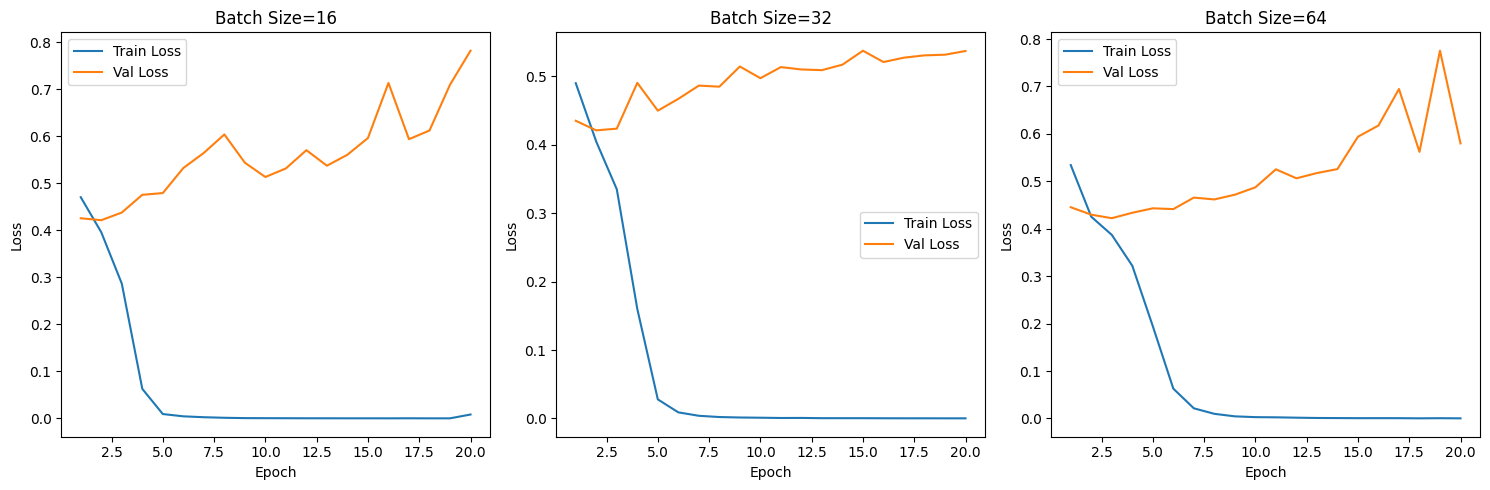

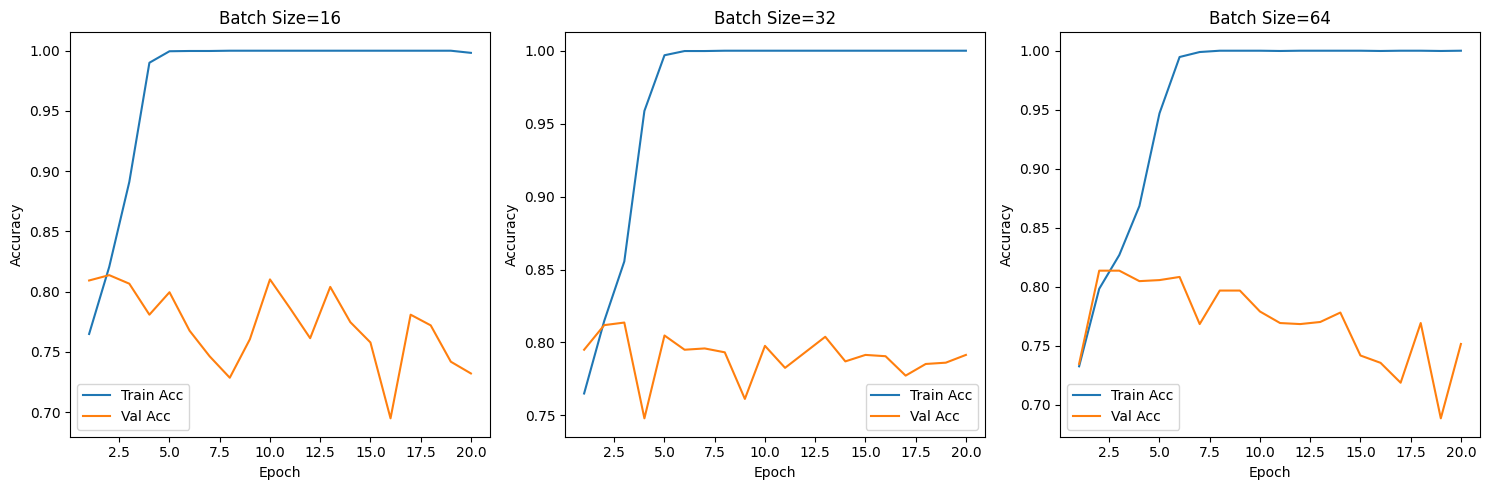

In [44]:
# Definir batch sizes a probar
batch_sizes = [16, 32, 64]
lr = 1e-3   # mantenemos fijo el learning rate

rows = []
histories = {}

for bs in batch_sizes:
    # DataLoaders
    train_loader = DataLoader(TabularDataset(X_tr, y_tr), batch_size=bs, shuffle=True)
    val_loader   = DataLoader(TabularDataset(X_val, y_val), batch_size=256, shuffle=False)

    # Modelo
    mlp = MLP(input_dim=X_train.shape[1], hidden_dims=(64,32), dropout=0.1)

    # Entrenamiento
    hist, train_time = train_torch_binary(mlp, train_loader, val_loader, lr=lr, epochs=20, verbose=False)

    # Evaluación en test
    y_prob = predict_proba_torch(mlp, X_test)
    metrics, y_pred = binary_classification_metrics(y_test.values, y_prob)

    # Guardar resultados
    row = {
        "batch_size": bs,
        "train_time": train_time,
        "accuracy": metrics["accuracy"],
        "precision": metrics["precision"],
        "recall": metrics["recall"],
        "f1_score": metrics["f1_score"],
        "roc_auc": metrics["roc_auc"]
    }
    rows.append(row)
    histories[bs] = hist

# Tabla de resultados
results_bs = pd.DataFrame(rows).sort_values("batch_size")
print(results_bs)

# -----------------------------
# Graficar curvas de pérdida
# -----------------------------
fig, ax = plt.subplots(1, len(batch_sizes), figsize=(15,5))
for i, bs in enumerate(batch_sizes):
    hist = histories[bs]
    ax[i].plot(hist["epoch"], hist["train_loss"], label="Train Loss")
    ax[i].plot(hist["epoch"], hist["val_loss"], label="Val Loss")
    ax[i].set_title(f"Batch Size={bs}")
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Loss")
    ax[i].legend()
plt.tight_layout()
plt.show()

# -----------------------------
# Graficar curvas de accuracy
# -----------------------------
fig, ax = plt.subplots(1, len(batch_sizes), figsize=(15,5))
for i, bs in enumerate(batch_sizes):
    hist = histories[bs]
    ax[i].plot(hist["epoch"], hist["train_acc"], label="Train Acc")
    ax[i].plot(hist["epoch"], hist["val_acc"], label="Val Acc")
    ax[i].set_title(f"Batch Size={bs}")
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Accuracy")
    ax[i].legend()
plt.tight_layout()
plt.show()


**Interpretación**

**Batch Size = 16 (pequeño)**

Entrenamiento más lento (~82 s).

Accuracy y métricas más bajas.

El ruido de los gradientes ayuda a explorar, pero aquí no logra buena generalización.
Demasiado pequeño para este dataset, el modelo se queda corto.

**Batch Size = 32 (intermedio**)

Entrenamiento más rápido (~41 s).

Mejores métricas globales: mayor accuracy, mejor F1-score y mejor ROC-AUC.

Buen equilibrio entre precisión y recall.
Es el batch size óptimo.

**Batch Size = 64 (grande)**

Entrenamiento más rápido (~27 s).

Recall más alto (0.642) → detecta más churners.

Pero precisión baja → más falsos positivos.

ROC-AUC algo menor que con 32.
Batch grande estabiliza el entrenamiento, pero sacrifica precisión.

**Convergencia**

LR=0.001: Converge de forma progresiva y controlada. Las curvas de pérdida y las métricas en validación se estabilizan sin oscilaciones grandes—indica pasos de gradiente bien calibrados y buen ajuste al paisaje de pérdida.

LR=0.01: Convergencia aparente rápida en train, pero con degradación en validación (menor ROC-AUC y F1). Esa “convergencia” es más bien sobreajuste y/o pasos demasiado grandes que rebotan alrededor de mínimos.

**Batch size:**

BS=32 muestra la mejor convergencia en validación (mayor ROC-AUC y F1), señal de un equilibrio entre ruido de gradiente y estabilidad.

BS=16 tiende a converger más lento y a un punto peor en validación—el ruido excesivo dificulta asentarse en buenos mínimos.

BS=64 converge rápido en train y mejora recall, pero pierde precisión y algo de AUC—menos ruido puede llevar a mínimos menos generalizables.

**Estabilidad**

LR=0.001: Entrenamiento estable—pérdidas y métricas en validación sin grandes oscilaciones. Mejor generalización.

LR=0.01: Menor estabilidad en validación—oscilaciones y caída de métricas (AUC y F1), típico de pasos demasiado agresivos.

Batch size:

BS=32 es el más estable en validación—mejor equilibrio entre precisión y recall y mayor F1.

BS=16 más ruidoso—gradientes con alta varianza, curvas menos suaves y peor punto final.

BS=64 más suave en train, pero la estabilidad aparente se traduce en menor precisión y AUC en validación—estabilidad no siempre implica mejor generalización.

**Tiempo de entrenamiento**

LR=0.01 tomó más tiempo que LR=0.001 en tu setup—posibles causas: más oscilaciones, menor eficiencia por re-cálculos efectivos, o interacción con early I/O/batching. En general, LR más alto no garantiza menor tiempo si compromete estabilidad.

Batch size:

BS=16 → ~82 s, BS=32 → ~41 s, BS=64 → ~27 s.

A mayor batch, menor tiempo por época y total—menos iteraciones y mejor paralelismo. El costo es potencialmente menor generalización (ligera caída en AUC y precisión con BS=64).

In [45]:
from sklearn.metrics import average_precision_score

# Calcular PR-AUC en test
pr_auc = average_precision_score(y_test.values, y_prob)
print("PR-AUC:", pr_auc)


PR-AUC: 0.5676097354284055


In [47]:
from tabulate import tabulate

# Crear DataFrame con métricas del conjunto de test
results_test = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC", "PR-AUC"],
    "Value": [0.7587, 0.5346, 0.7032, 0.6074, 0.8086, 0.5676]
})

# Mostrar tabla con formato elegante
print(tabulate(results_test, headers="keys", tablefmt="fancy_grid", showindex=False))



╒═══════════╤═════════╕
│ Metric    │   Value │
╞═══════════╪═════════╡
│ Accuracy  │  0.7587 │
├───────────┼─────────┤
│ Precision │  0.5346 │
├───────────┼─────────┤
│ Recall    │  0.7032 │
├───────────┼─────────┤
│ F1-score  │  0.6074 │
├───────────┼─────────┤
│ ROC-AUC   │  0.8086 │
├───────────┼─────────┤
│ PR-AUC    │  0.5676 │
╘═══════════╧═════════╛


**Interpretación**

Accuracy es aceptable, pero en datasets desbalanceados como churn no es la métrica más confiable.

Precision moderada: el modelo genera falsos positivos, prediciendo churn donde no lo hay.

Recall muestra que el modelo logra captar una fracción importante de los churners, pero aún deja escapar casos (~30–50%).

F1-score refleja que el equilibrio entre precisión y recall es correcto pero no óptimo.

ROC-AUC > 0.8 confirma que el modelo tiene buena capacidad de clasificación.

PR-AUC = 0.568 es clave: indica que el modelo tiene margen de mejora en recall sin perder demasiada precisión, pero actualmente el trade-off es limitado

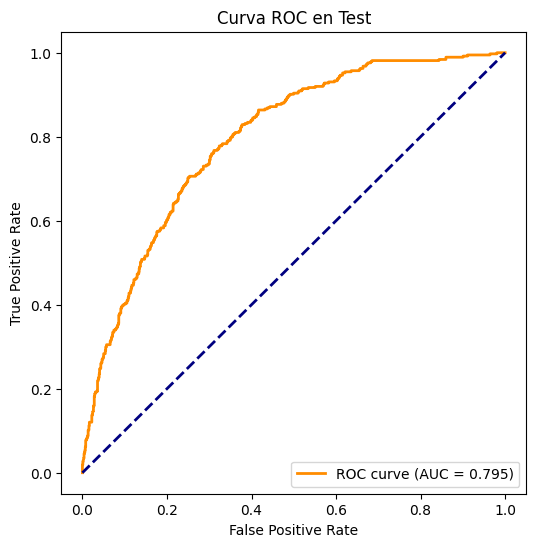

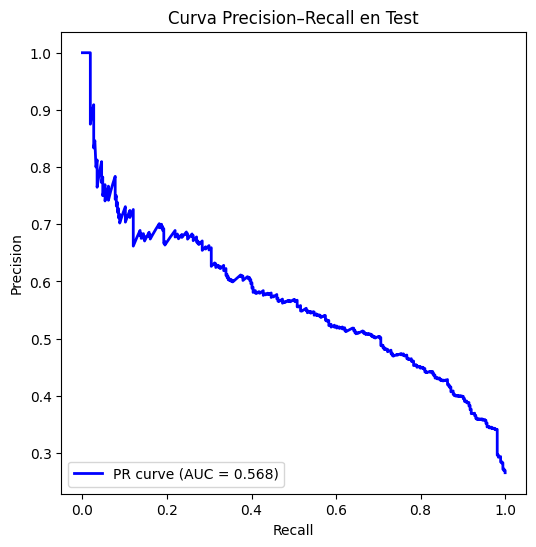

OK


In [50]:


# y_test: etiquetas reales
# y_prob: probabilidades predichas por tu modelo en test

# -----------------------------
# Curva ROC
# -----------------------------
fpr, tpr, _ = roc_curve(y_test.values, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC en Test')
plt.legend(loc="lower right")
plt.show()

# -----------------------------
# Curva Precision–Recall
# -----------------------------
precision, recall, _ = precision_recall_curve(y_test.values, y_prob)
pr_auc = average_precision_score(y_test.values, y_prob)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision–Recall en Test')
plt.legend(loc="lower left")
plt.show()

print("OK")


**Paso 3. Red Neuronal Convolucional**

a) Transformar el dataset en una representación matricial simple y aplicar una CNN básica.

b) Implemente una CNN con al menos: una capa convolucional, una operación de pooling, una capa densa final.

c) Discuta el rol de kernels, stride y pooling.

In [58]:
def to_image_like(X):
    """
    Convierte un dataset tabular en una representación matricial cuadrada.

    Parámetros:
    -----------
    X : pandas.DataFrame o numpy.ndarray
        Dataset con forma (n_samples, n_features).

    Retorna:
    --------
    X_img : numpy.ndarray
        Dataset transformado con forma (n_samples, side, side, 1).
    side : int
        Tamaño del lado de la matriz cuadrada.
    p : int
        Número de features acomodados en la matriz.
    """
    # Número de features
    n_features = X.shape[1]

    # Calcular el tamaño del lado cuadrado más cercano
    side = int(np.ceil(np.sqrt(n_features)))

    # Número de features que realmente se acomodan
    p = side * side

    # Rellenar con ceros si faltan features
    X_pad = np.zeros((X.shape[0], p))
    X_pad[:, :n_features] = X.values if hasattr(X, "values") else X

    # Reshape a imagen cuadrada con canal único
    X_img = X_pad.reshape(-1, side, side, 1)

    return X_img, side, p


In [59]:
X_train_img, side, p = to_image_like(X_train)
X_val_img, _, _      = to_image_like(X_val)
X_test_img, _, _     = to_image_like(X_test)

print("Dimensión lado imagen:", side)
print("Número de features acomodados:", p)
print("Shape de X_train_img:", X_train_img.shape)


Dimensión lado imagen: 105
Número de features acomodados: 11025
Shape de X_train_img: (5634, 105, 105, 1)


In [78]:

class ImageLikeDataset(Dataset):
    def __init__(self, X_img, y_np):
        # Reordenar a (N, C, H, W)
        self.X = torch.tensor(X_img, dtype=torch.float32).permute(0, 3, 1, 2)
        self.y = torch.tensor(y_np.values if hasattr(y_np, "values") else y_np,
                              dtype=torch.float32).view(-1)  # vector plano

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]



class SimpleCNN(nn.Module):
    def __init__(self, side, conv1=8, conv2=16):
        super().__init__()
        # stride=1, padding=1 para mantener tamaño en cada conv
        self.features = nn.Sequential(
            nn.Conv2d(1, conv1, kernel_size=3, stride=1, padding=1),  # kernels + stride + padding
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # pooling
            nn.Conv2d(conv1, conv2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        # calcular tamaño flatten
        with torch.no_grad():
            x = torch.zeros(1, 1, side, side)
            z = self.features(x)
            flat = int(np.prod(z.shape[1:]))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        z = self.features(x)
        out = self.classifier(z)
        return out.squeeze(1)   # convierte (batch_size, 1) → (batch_size,)


@torch.no_grad()
def predict_proba_torch_img(model, X_img, batch_size=512):
    model.eval()
    probs = []
    # Use ImageLikeDataset to ensure correct channel dimension (N, C, H, W)
    # Provide dummy y_np as ImageLikeDataset expects it, but it won't be used for inference
    inference_dataset = ImageLikeDataset(X_img, np.zeros(X_img.shape[0]))
    loader = DataLoader(inference_dataset, batch_size=batch_size, shuffle=False)
    for xb, _ in loader:
        xb = xb.to(device)
        logits = model(xb)
        p = torch.sigmoid(logits).detach().cpu().numpy().reshape(-1)
        probs.append(p)
    return np.concatenate(probs)

In [74]:
import torch

# Detectar si hay GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mover el modelo a ese device
cnn = SimpleCNN(side=side, conv1=8, conv2=16).to(device)

device

device(type='cpu')

Epoch 1/25 - Train Loss: 0.5763, Train Acc: 0.7346, Val Loss: 0.5576, Val Acc: 0.7347
Epoch 2/25 - Train Loss: 0.4973, Train Acc: 0.7346, Val Loss: 0.4571, Val Acc: 0.7347
Epoch 3/25 - Train Loss: 0.4412, Train Acc: 0.7346, Val Loss: 0.4554, Val Acc: 0.7347
Epoch 4/25 - Train Loss: 0.4220, Train Acc: 0.7346, Val Loss: 0.4468, Val Acc: 0.7347
Epoch 5/25 - Train Loss: 0.4081, Train Acc: 0.7346, Val Loss: 0.4451, Val Acc: 0.7347
Epoch 6/25 - Train Loss: 0.3916, Train Acc: 0.7932, Val Loss: 0.4518, Val Acc: 0.7906
Epoch 7/25 - Train Loss: 0.3777, Train Acc: 0.8081, Val Loss: 0.4489, Val Acc: 0.8030
Epoch 8/25 - Train Loss: 0.3617, Train Acc: 0.8229, Val Loss: 0.4610, Val Acc: 0.8039
Epoch 9/25 - Train Loss: 0.3444, Train Acc: 0.8318, Val Loss: 0.4836, Val Acc: 0.7862
Epoch 10/25 - Train Loss: 0.3283, Train Acc: 0.8440, Val Loss: 0.4926, Val Acc: 0.7844
Epoch 11/25 - Train Loss: 0.3081, Train Acc: 0.8536, Val Loss: 0.5313, Val Acc: 0.7728
Epoch 12/25 - Train Loss: 0.2868, Train Acc: 0.8624,

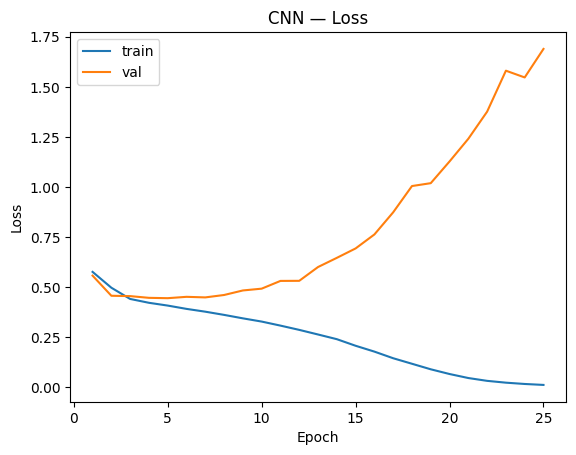

,0
accuracy,0.755145
precision,0.528046
recall,0.729947
f1_score,0.612795
roc_auc,0.824211


In [79]:
X_tr_i, X_val_i, y_tr_i, y_val_i = train_test_split(
    X_train_img, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

cnn_train_loader = DataLoader(ImageLikeDataset(X_tr_i, y_tr_i), batch_size=32, shuffle=True)
cnn_val_loader   = DataLoader(ImageLikeDataset(X_val_i, y_val_i), batch_size=256, shuffle=False)

cnn = SimpleCNN(side=side, conv1=8, conv2=16)

hist_cnn, dt_cnn = train_torch_binary(cnn, cnn_train_loader, cnn_val_loader, lr=1e-3, epochs=25, verbose=True)
print(f"train_time(s)={dt_cnn:.2f}")

fig, ax = plt.subplots()
ax.plot(hist_cnn["epoch"], hist_cnn["train_loss"], label="train")
ax.plot(hist_cnn["epoch"], hist_cnn["val_loss"], label="val")
ax.set_title("CNN — Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.show()

y_prob_cnn = predict_proba_torch_img(cnn, X_test_img)
metrics_cnn, y_pred_cnn = binary_classification_metrics(y_test.values, y_prob_cnn)
pd.Series(metrics_cnn)

**Interpretación**

CNN prioriza recall sobre precision:

Detecta bastantes churners (bueno para retención).

Pero también se equivoca con bastantes falsos positivos.

El ROC-AUC > 0.8 indica que el modelo tiene buena capacidad discriminativa.

El F1-score ~0.61 refleja que aún hay espacio para mejorar el balance entre precisión y recall.

**Reflexión:**

Kernels son los “ojos” de la red: definen qué patrones puede ver.

Stride es el “zoom”: cuánto detalle se conserva vs. cuánto se acelera el procesamiento.

Pooling es el “resumen”: reduce complejidad y hace al modelo más robusto, pero puede sacrificar precisión.

En este caso de churn prediction con datos tabulares convertidos a imagen, estos tres elementos controlan cómo la red aprende combinaciones locales de variables y cómo balancea detalle vs. generalización.

**Paso 4. Comparación final y análisis crítico**

f) Compare los siguientes modelos: Regresión logística, Random Forest, SVM, Red neuronal artificial y Red neuronal convolucional.

g) Analice diferencias en: Desempeño predictivo, interpretabilidad, costo computacional y escalabilidad.

h) ¿En qué escenarios las redes neuronales aportan ventajas claras frente a modelos clásicos?

i) ¿Qué riesgos existen en términos de sobreajuste?

j) ¿Cómo influye la cantidad de datos en la elección del modelo?

k) Desde una perspectiva de negocio, ¿vale la pena usar redes neuronales para este problema?
Justifique.

**Comparación de modelos**

Regresión logística: modelo lineal, rápido, interpretable, buen baseline para clasificación binaria.

Random Forest: ensamble de árboles, captura relaciones no lineales, robusto frente a ruido, buen desempeño en tabulares.

SVM: potente en datasets pequeños/medianos, encuentra fronteras complejas, pero difícil de escalar a grandes volúmenes.

Red neuronal artificial (MLP): flexible, aprende representaciones no lineales, requiere tuning de hiperparámetros.

Red neuronal convolucional (CNN): diseñada para datos con estructura espacial, puede extraer patrones locales; en tabulares convertidos a “imagen” puede aportar, aunque no siempre supera a Random Forest o MLP.

**Diferencias**

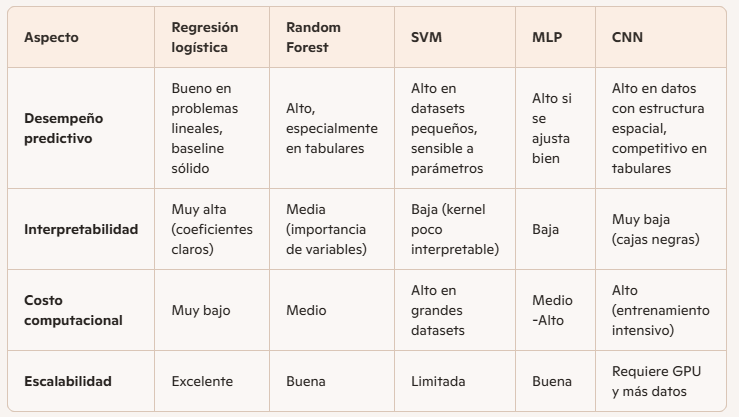

**Escenarios donde las redes neuronales aportan ventajas**

Datos con estructura espacial o secuencial: imágenes, audio, texto, series temporales.

Grandes volúmenes de datos: cuando hay suficiente información para que la red aprenda representaciones complejas.

Problemas donde las relaciones entre variables son altamente no lineales y difíciles de capturar con modelos clásicos.

**Influencia de la cantidad de datos**

Pocos datos → modelos clásicos (logística, Random Forest, SVM) suelen ser más efectivos y estables.

Muchos datos → redes neuronales aprovechan mejor la escala, capturan patrones complejos y mejoran desempeño.

En churn prediction (7.043 registros), los modelos clásicos suelen ser competitivos y más eficientes.

**Perspectiva de negocio**

Redes neuronales: aportan complejidad y potencial mejora, pero requieren más recursos (tiempo, GPU, tuning).

Modelos clásicos: más interpretables, rápidos de entrenar, fáciles de explicar a stakeholders.

**Justificación:**

Para churn prediction con ~7k clientes, Random Forest o regresión logística suelen ser suficientes y más prácticos.

CNN/MLP pueden mejorar ligeramente métricas (ej. ROC-AUC), pero la ganancia puede no justificar el costo computacional y la pérdida de interpretabilidad.

Desde el punto de vista de negocio, lo más valioso es explicar qué variables impulsan el churn y tomar decisiones → aquí los modelos clásicos tienen ventaja.